<a href="https://colab.research.google.com/github/diegofuentes51/LAB13/blob/main/LABORATORIO13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Distribución de clases en todo el conjunto de datos:
actual_productivity
1    1064
0     133
Name: count, dtype: int64


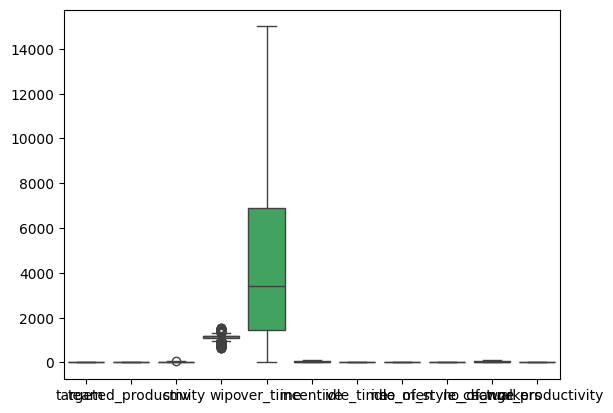

Distribución de clases en y_train después de la división estratificada:
actual_productivity
0.0    634
Name: count, dtype: int64
No es necesario aplicar SMOTE, ya que solo hay una clase en el conjunto de entrenamiento.
El conjunto de entrenamiento sigue teniendo solo una clase. Es necesario revisar los datos y la división.


In [20]:
# Aquí importo todas las librerías necesarias para trabajar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# Paso 1: Cargo los datos desde el archivo CSV
df = pd.read_csv('/content/garments_worker_productivity.csv')

# Paso 2: Elimino la columna 'date', ya que no la necesito
df = df.drop(columns=['date'])

# Paso 3: Hago que la variable 'actual_productivity' sea binaria (0 o 1)
df['actual_productivity'] = df['actual_productivity'].apply(lambda x: 1 if x >= 0.5 else 0)

# Paso 4: Veo cómo están distribuidas las clases en los datos
print("Distribución de clases en todo el conjunto de datos:")
print(df['actual_productivity'].value_counts())

# Paso 5: Relleno los valores faltantes de la columna 'wip' con la media
df['wip'] = df['wip'].fillna(df['wip'].mean())

# Paso 6: Detecto y elimino los outliers utilizando el método del IQR
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Paso 7: Veo cómo quedaron las columnas numéricas después de eliminar los outliers
sns.boxplot(data=df_cleaned[numerical_cols])
plt.show()

# Paso 8: Convierto las columnas categóricas en variables dummy (ficticias)
df_cleaned = pd.get_dummies(df_cleaned, drop_first=True)

# Paso 9: Escalo las columnas numéricas para que todas tengan la misma escala
scaler = StandardScaler()
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])

# Paso 10: Separo las variables predictoras (X) y la variable objetivo (y)
X = df_cleaned.drop(columns=['actual_productivity'])
y = df_cleaned['actual_productivity']

# Paso 11: Divido los datos de manera estratificada para asegurarme de que ambas clases estén en el conjunto de entrenamiento
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Paso 12: Reviso la distribución de clases en el conjunto de entrenamiento
print("Distribución de clases en y_train después de la división estratificada:")
print(y_train.value_counts())

# Paso 13: Si las clases están muy desbalanceadas, aplico SMOTE para balancearlas
if y_train.value_counts().shape[0] > 1:  # Solo si hay más de una clase
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("Distribución de clases después de SMOTE:")
    print(pd.Series(y_train_res).value_counts())
else:
    # Si no se aplica SMOTE, simplemente uso los datos originales
    X_train_res, y_train_res = X_train, y_train
    print("No es necesario aplicar SMOTE, ya que solo hay una clase en el conjunto de entrenamiento.")

# Paso 14: Me aseguro de que haya más de una clase en el conjunto de entrenamiento
if y_train_res.value_counts().shape[0] > 1:
    # Paso 15: Inicializo los modelos que voy a usar
    models = {
        "k-NN": KNeighborsClassifier(),
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Naive Bayes": GaussianNB()
    }

    # Paso 16: Entreno y evalúo cada modelo
    for model_name, model in models.items():
        model.fit(X_train_res, y_train_res)  # Entreno con los datos balanceados o originales
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy {model_name}: {accuracy}")

    # Paso 17: Busco los mejores hiperparámetros para los modelos k-NN y SVM
    param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
    grid_search_knn.fit(X_train_res, y_train_res)
    print("Mejores hiperparámetros para k-NN:", grid_search_knn.best_params_)

    param_dist_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    random_search_svm = RandomizedSearchCV(SVC(), param_dist_svm, n_iter=10, cv=5)
    random_search_svm.fit(X_train_res, y_train_res)
    print("Mejores hiperparámetros para SVM:", random_search_svm.best_params_)

    # Paso 18: Evaluación del modelo con los mejores hiperparámetros
    best_knn_model = grid_search_knn.best_estimator_
    y_pred_best_knn = best_knn_model.predict(X_test)
    best_knn_accuracy = accuracy_score(y_test, y_pred_best_knn)
    print(f"Mejor accuracy para k-NN con hiperparámetros óptimos: {best_knn_accuracy}")

    best_svm_model = random_search_svm.best_estimator_
    y_pred_best_svm = best_svm_model.predict(X_test)
    best_svm_accuracy = accuracy_score(y_test, y_pred_best_svm)
    print(f"Mejor accuracy para SVM con hiperparámetros óptimos: {best_svm_accuracy}")

else:
    print("El conjunto de entrenamiento sigue teniendo solo una clase. Es necesario revisar los datos y la división.")
